## Transfer Learning on Flowers Dataset

<a href="https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz">Download Dataset</a>&emsp;<a href="https://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.pdf">Official Paper</a>&emsp;<a href="https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1">Download Labels</a>

---

#### Project Description
This project is 



### Table of Content:
* [Read the Data](#read-data)






### What I want to cover
* Image segmentation foreground 
* Find statistical models to use to show the variations | similarity detection
* 


## TO REDO
* Make class to store training/test/optim and criterion -> store results! 
* Add more description 
* Add jumping from one part to another
* Add table of content 
* Look at more description and state-of-the-art image processing 

In [1]:
# !pip install plotly

In [2]:
# import essential packages
import os
import random

import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import plotly.express as px

import torch
from torch import nn
from torch import optim
import torchvision.models as models

# additional helper function to do behind the scene
import helper
import visualize
import train_test

sns.set()

In [3]:
# unzip the jpg folder and store locally
# with ZipFile('jpg.zip', 'r') as f:
#     f.extractall()

### Read the data <a class="anchor" id="read-data">
The data provided by the fellowship-ai was presented in a huge folder with 8189 images along with text files containing training, test, and validation paths and their respective targets.  

![Folder Structure](images/structure.png)
    
Instead of finding the formatted folders online, I decided to take some time to deal with formatting manually. The formatting is essential for further usage of ImageFolder and DataLoader to read, transform, and create batches of data. To be able to use these functions, we need to have the following folder structure:
```
root/class_1/xxx.jpg
root/class_1/xxy.jpg
root/class_1/xxz.jpg

root/class_2/123.jpg
root/class_2/nsdf3.jpg
root/class_2/asd932_.jpg
```

#### Steps to take:
* Read the content of three sets (train, test, and validation)
* Create a dataframe to store all paths and targets <b>if</b> 'jpg' folder exists (to transfer the images to correct folders)
* Increase the index of all DataFrames and Series by 1 (indexing starts from 1 in target column)
* Create two target dictionaries to store <i>number:column</i> and <i>column:number</i> for better visualization 
* Create folders and transfer images from 'jpg' to their respective folders
    
---
#### Explanations 
<b>Why create a DataFrame to store all paths and targets?</b> Since I'm manually creating the folders, there was the need to iterate over the whole file and transfer the images accordingly.<br>
<b>Why increase by 1?</b> While creating the dataframes, their indices automatically start from 0. During the visualization step, I saw that the labels were interpreted incorrectly. At that time I realized that indexing of targets in the MATLAB file start from 1. 


In [3]:
# read the paths and targets, store them in dataframes 
train_df = pd.read_csv('paths/train.txt', sep=' ', names=['path', 'idx'])
test_df = pd.read_csv('paths/test.txt', sep=' ', names=['path', 'idx'])
valid_df = pd.read_csv('paths/valid.txt', sep=' ', names=['path', 'idx'])

# check the number of images in each dataframe
for df, name in [(train_df, 'train'), (test_df, 'test'), (valid_df, 'validation')]:
    print(f'{name} contains {df.shape[0]} images')

train contains 1020 images
test contains 6149 images
validation contains 1020 images


In [4]:
# if the 'jpg' file exists, create a dataframe to store all paths and targets
if os.path.exists('jpg'):
    # MATLAB returns a tuple, we need the first value which stores the array of target indices
    labels = scipy.io.loadmat('paths/imagelabels.mat')['labels'][0]
    # get all filenames from 'jpg' directory
    dataset = os.listdir('jpg')
    # store both results in a dataframe
    df = pd.DataFrame({'path': dataset, 'target': labels})
    # create a dataframe to not break the code after folder creation 
    df.to_csv('paths/dataframe.csv', index=False)

# otherwise read the existing dataframe
else:
    df = pd.read_csv('paths/dataframe.csv')

# read the class names and increase index by 1 
classes = pd.read_csv('paths/class_names.txt', names=['target'])
classes.index += 1

# remove the unnecessary punctuation marks 
label_dict, label_inverse = labels_dict = helper.prettify(classes)

# check for correctness 
next(iter(label_dict.items()))

(1, 'Pink Primrose')

In [5]:
#### Main part to create and transfer images ####

# helper.create_folders(df)   ## uncomment if you need to create the folders

# transfer the images from "jpg" folder to their appropriate files 
# helper.transfer([train_df, test_df, valid_df], df)   ## uncomment to transfer images

### Success! 
Now the folders are in the format that I initially wanted to work with. They have the following format: <br>
![](images/right_folder.png)

However, there biggest issue is that PyCharm automatically sorts folders alphabetically. When I created the folders, I was using numbers to initialize them, thus the IDE did its intelligent thing to prettify the results by sorting them as <b>numbers</b>. When the DataLoader checks the structure, it reads them as <b>strings</b>. I had to manually create a holder which stores the DataLoader structure. It was done by writing this complex structure:<br>
<code>sorted([str(x) for x in df['target'].unique().astype('object').tolist()])</code><br>

<b>Let's break it down</b>:
1. Get the unique instances of target column (1-102);
2. Change the data type, so it is not a number anymore;
3. Turn pandas Series to list;
4. Convert each instances to string;
5. Sort alphabetically

As a result, we get the following <b>correct</b> structure: <br>
<code> 1, 10, 100, 101, 102, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 
    29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 
    52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 
    76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99</code>


#### Trials 
At the very beginning, I wanted to create a string representation of folders with their actual names. However, doing so increased the complexity of finding the label's patterns in the visualization step. It was labeling sunflowers as roses, wallflowers as orange dahlia, and so on. I was sure there was a bug that I failed to look at. And after around 18-25 hours, thanks to <a href='https://github.com/pytorch/vision/issues/714'>this reply</a>, everything made sense! Here's the initial folder screenshot:
![](images/wrong_folders.png)

### Create the loaders
To not clutter the main page, this transformation happens in the helper function as well. 

In [6]:
# set the batch size
n_batches = 20

train_loader, test_loader, valid_loader = helper.create_loaders(n_batches)

### Visualize the data
Over here I want to visualize a whole batch of images

In [7]:
batch = iter(train_loader)

actual_order = sorted([str(x) for x in df['target'].unique().astype('object').tolist()])

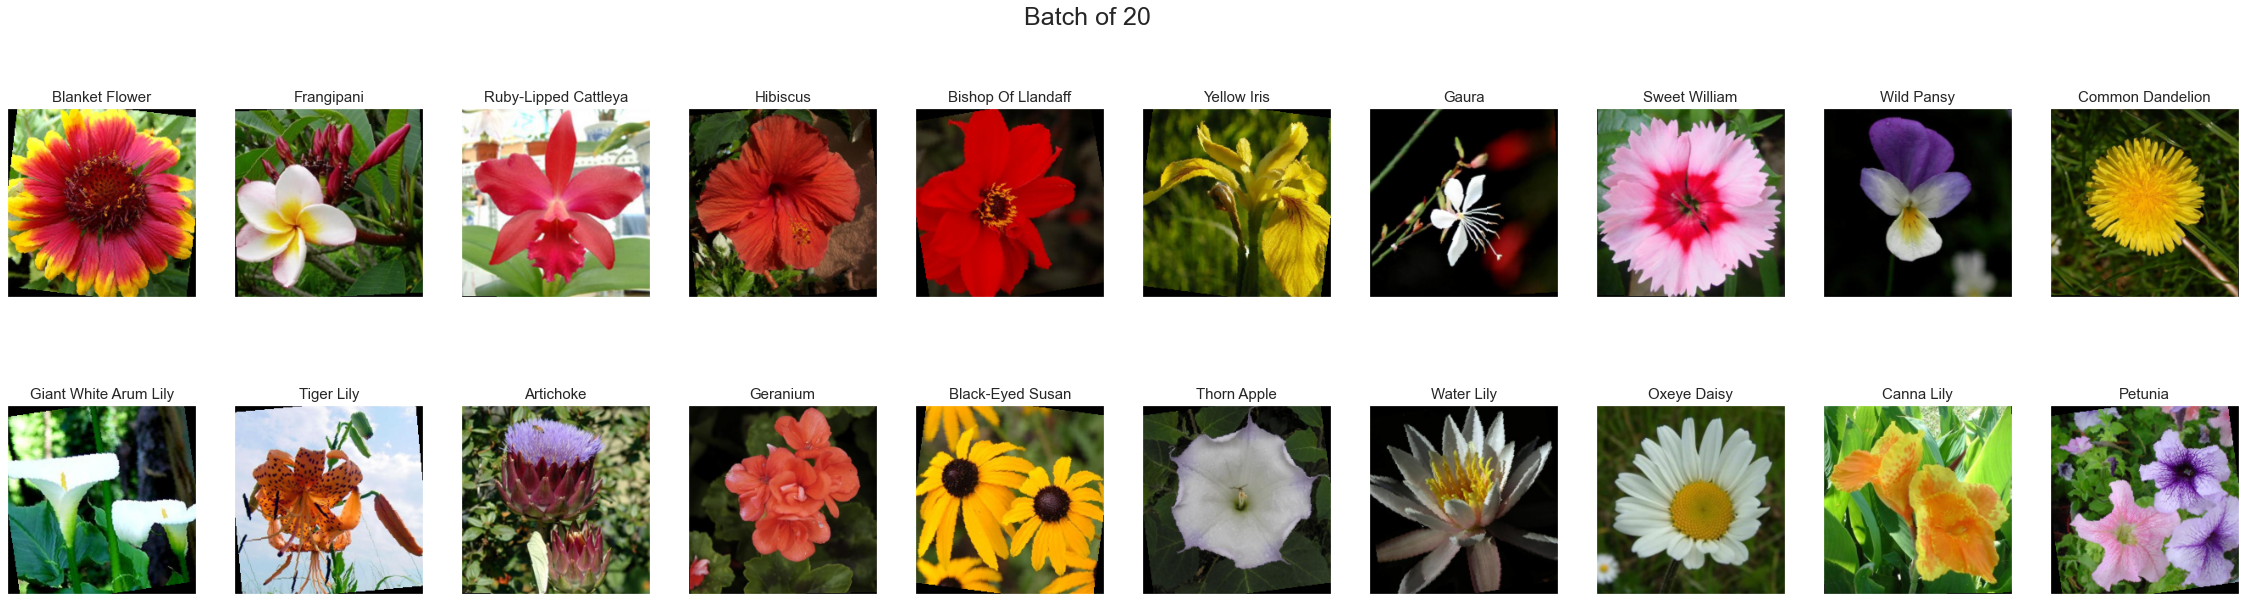

In [8]:
visualize.batch(batch, label_dict, n_batches, actual_order)

### Visualize the distribution of flowers
Since we already know that there are 1020 instances in the training set, I want to check the number of images in each class. The importance of doing so is to see if there's a class imbalance that needs to be taken care of. As we see, there's an equal distribution of the images, which is incredible! 

There are 10 images in each folder


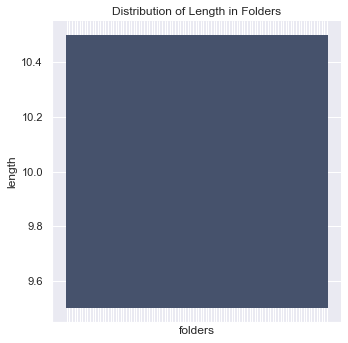

In [9]:
visualize.hist(targets=label_dict)

### Time to train our model!
This part is just to see how well the model does to make changes accordingly. The model that is being used is ResNet34 on Adagrad optimizer and CrossEntropyLoss. 
The choice to use Adagrad was due to ...
CrossEntropy is the loss function to get ...

In [10]:
# model = models.resnet34(pretrained=True)

In [11]:
# transfer to CUDA if applicable
use_cuda = torch.cuda.is_available()

def get_model():
    model = models.resnet34(pretrained=True)
    # change the out features
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 102)

    if use_cuda:
        model = model.cuda()
    return model

In [12]:
batches = [10, 20]
results = []

for idx in range(2):
    model = get_model()

    batch = batches[idx]
    path = f'sgd_momentum{batch}batches.pt'

    train_loss, valid_loss, test_loss, model, confused_with, test_dict = train_test.set_params(
        10, model, label_dict, actual_order, use_cuda, save_path=path,
        learning_decay=True, optim_name='SGD', n_batch=batch)

    results.append({'train_loss': train_loss, 'valid_loss': valid_loss, 'test_loss': test_loss,
                   'confused_with': confused_with, 'test_dict': test_dict, 'path': path,
                    'optim': 'SGD', 'batch_size': batch})

    path = f'adagrad{batch}batches.pt'
    train_loss, valid_loss, test_loss, model, confused_with, test_dict = train_test.set_params(
        10, model, label_dict, actual_order, use_cuda, save_path=path,
        learning_decay=True, optim_name='Ada', n_batch=batch)

    results.append({'train_loss': train_loss, 'valid_loss': valid_loss, 'test_loss': test_loss,
                   'confused_with': confused_with, 'test_dict': test_dict, 'path': path,
                    'optim': 'Adagrad', 'batch_size': batch})


========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: SGD
    Batch size: 10
    Path: sgd_momentum10batches.pt
    


c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 3.864423).  Saving model ...
Validation loss decreased (3.864423 --> 3.163825).  Saving model ...


KeyboardInterrupt: 

In [12]:
# num_epochs = 30
# criterion = nn.CrossEntropyLoss()

# def get_optimizer(model):
#     """
#     """
#     optimizer = optim.Adagrad(model.parameters(), lr=0.01)
#     lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
#     return optimizer, lr_decay


In [16]:
# train_losses = []
# valid_losses = []


# def train(n_epochs:int, loaders:dict, model, optimizer, criterion, use_cuda:bool,
#          save_path:str, learning_decay):
#     """
#     This function trains the model and shows the progress.

#     Parameters:
#         n_epochs (int): Number of epochs to train for
#         loaders (dict): Dictionary of loaders to use
#         model: Model being used
#         optimizer: Selected optimizer
#         criterion: Loss function
#         use_cuda (bool): If GPU is enables or not
#         save_path (str): Path to store the results in
#         learning_decay_scheduler: Learning rate decay scheduler to use

#     Returns:
#         A trained model
#     """
#     # initialize tracker for minimum validation loss
#     valid_loss_min = np.Inf 
    
#     for epoch in range(1, n_epochs+1):
#         # initialize variables to monitor training and validation loss
#         train_loss = 0.0
#         valid_loss = 0.0
        
#         ###################
#         # train the model #
#         ###################
#         # set the module to training mode
#         model.train()
#         for batch_idx, (data, target) in enumerate(loaders['train']):
#             # move to GPU
#             if use_cuda:
#                 data, target = data.cuda(), target.cuda()
                
#             # record the average training loss, using something like
#             optimizer.zero_grad()
            
#             # get the final outputs
#             output = model(data)
            
#             # calculate the loss
#             loss = criterion(output, target)
            
#             # start back propagation
#             loss.backward()
            
#             # update the weights
#             optimizer.step()
            
#             train_loss += loss.item() * data.size(0)

#         ######################    
#         # validate the model #
#         ######################
#         # set the model to evaluation mode
#         model.eval()
#         for batch_idx, (data, target) in enumerate(loaders['valid']):
#             # move to GPU
#             if use_cuda:
#                 data, target = data.cuda(), target.cuda()

#             ## update average validation loss 
#             output = model(data)
#             loss = criterion(output, target)
#             valid_loss += loss.item() * data.size(0)
        
#         train_loss /= len(train_loader.sampler)
#         valid_loss /= len(valid_loader.sampler)
        
#         train_losses.append(train_loss)
#         valid_losses.append(valid_loss)
        
#         # print training/validation statistics every 5 epochs
#         if epoch % 5 == 0:
#             print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
#                 epoch, 
#                 train_loss,
#                 valid_loss
#                 ))

#         ## if the validation loss has decreased, save the model at the filepath stored in save_path
#         if valid_loss <= valid_loss_min:
#             print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
#             torch.save(model.state_dict(), save_path)
#             valid_loss_min = valid_loss

#         # update learning rate decay
#         learning_decay.step()
            
#     return model

In [60]:
# test_dict = {}
# confused_with = {}

# def test(loaders, model, criterion, use_cuda):
#     """
#     This functions calculates the correctness and shows the results of the architecture.

#     Parameters:
#         loaders: Dictionary that stores all three loaders
#         model: Model used for implementation
#         criterion: Loss function
#         use_cuda: If GPU is available or not

#     Returns:
#         The accuracy of the model
#     """
#     # monitor test loss and accuracy
#     test_loss = 0.
#     correct = 0.
#     total = 0.

#     # keep track of correctly classified classes
#     class_correct = list(0. for _ in range(102))
#     class_total = list(0. for _ in range(102))

#     # set the module to evaluation mode
#     model.eval()

#     for batch_idx, (data, target) in enumerate(loaders['test']):
#         # move to GPU
#         if use_cuda:
#             data, target = data.cuda(), target.cuda()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
        
#         # calculate the loss
#         loss = criterion(output, target)
        
#         # update average test loss 
#         test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        
#         # convert output probabilities to predicted class
#         pred = output.data.max(1, keepdim=True)[1]
        
#         # compare predictions to true label
#         correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
#         total += data.size(0)

#         for i in range(len(target)):
#             label = target.data[i]
            
#             if int(label) not in confused_with:
#                 confused_with[int(label)] = []
#             else:
#                 confused_with[int(label)].append(pred[i].item())
            
#             class_correct[label] += np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy()[i].item()
#             class_total[label] += 1
#     # show the accuracy
#     print('Test Loss: {:.6f}\n'.format(test_loss))

#     print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
#         100. * correct / total, correct, total))

#     for i in range(102):
#         if class_total[i] > 0:
#             name = label_dict[int(actual_order[i])]
#             accuracy = 100*class_correct[i] / class_total[i]
#             print(f'Test Accuracy of {name}: %{accuracy}'
#                   f'({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
#             test_dict[name] = accuracy

In [14]:
model = models.resnet34(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# transfer to CUDA if applicable
use_cuda = torch.cuda.is_available()

# change the out features
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 102)

if use_cuda:
    model = model.cuda()

# loaders = {'train': train_loader, 'test': test_loader, 'valid': valid_loader}
# optimizer, lr_decay = get_optimizer(model)

In [20]:
# model = train(num_epochs, loaders, model, optimizer, criterion, use_cuda, 'resnet34.pt', lr_decay)


Validation loss decreased (inf --> 4.610779).  Saving model ...
Validation loss decreased (4.610779 --> 4.448485).  Saving model ...
Validation loss decreased (4.448485 --> 4.428408).  Saving model ...
Validation loss decreased (4.428408 --> 3.769590).  Saving model ...
Epoch: 5 	Training Loss: 3.775674 	Validation Loss: 3.939117
Validation loss decreased (3.769590 --> 3.552093).  Saving model ...
Validation loss decreased (3.552093 --> 3.307918).  Saving model ...
Validation loss decreased (3.307918 --> 3.123335).  Saving model ...
Epoch: 10 	Training Loss: 2.862704 	Validation Loss: 3.094968
Validation loss decreased (3.123335 --> 3.094968).  Saving model ...
Validation loss decreased (3.094968 --> 2.852732).  Saving model ...
Validation loss decreased (2.852732 --> 2.721962).  Saving model ...
Validation loss decreased (2.721962 --> 2.567313).  Saving model ...
Epoch: 15 	Training Loss: 2.038910 	Validation Loss: 2.536955
Validation loss decreased (2.567313 --> 2.536955).  Saving mo

In [61]:
# load the model that got the best validation accuracy
# model.load_state_dict(torch.load('resnet34.pt'))    ## GPU version

model.load_state_dict(torch.load('resnet34.pt', map_location=torch.device('cpu')))

# check the test results
test(loaders, model, criterion, use_cuda)

Test Loss: 2.169558


Test Accuracy: 47% (2933/6149)
Test Accuracy of Pink Primrose: %50.0(10.0/20.0)
Test Accuracy of Globe Thistle: %88.0(22.0/25.0)
Test Accuracy of Blanket Flower: %72.41379310344827(21.0/29.0)
Test Accuracy of Trumpet Creeper: %39.473684210526315(15.0/38.0)
Test Accuracy of Blackberry Lily: %60.714285714285715(17.0/28.0)
Test Accuracy of Snapdragon: %19.402985074626866(13.0/67.0)
Test Accuracy of Colt: %76.11940298507463(51.0/67.0)
Test Accuracy of King Protea: %79.3103448275862(23.0/29.0)
Test Accuracy of Spear Thistle: %67.85714285714286(19.0/28.0)
Test Accuracy of Yellow Iris: %62.06896551724138(18.0/29.0)
Test Accuracy of Globe-Flower: %33.333333333333336(7.0/21.0)
Test Accuracy of Purple Coneflower: %76.92307692307692(50.0/65.0)
Test Accuracy of Peruvian Lily: %33.87096774193548(21.0/62.0)
Test Accuracy of Balloon Flower: %34.48275862068966(10.0/29.0)
Test Accuracy of Hard-Leaved Pocket Orchid: %67.5(27.0/40.0)
Test Accuracy of Giant White Arum Lily: %30.55555

### Visualize the results 

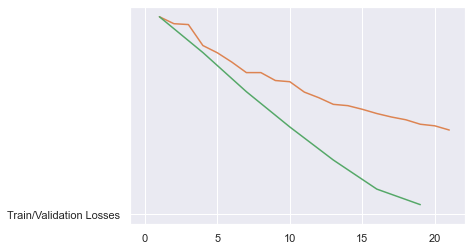

In [14]:
# training and validation scores 
# valid_losses = [4.610779, 4.448485, 4.428408, 3.939117, 3.769590,
#                 3.552093, 3.307918, 3.307918, 3.123335, 3.094968,
#                 2.852732, 2.721962, 2.567313, 2.536955, 2.451873,
#                 2.353321, 2.272735, 2.207868, 2.103460, 2.066408,
#                 1.968210]

# train_losses = [4.610779, 3.775674, 2.862704, 2.038910, 1.268716,
#                 0.590261, 0.227693]

# plt.title('Train/Validation Losses')
# plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses)
# plt.plot(np.arange(1, len(valid_losses) + 1, step=3), train_losses)
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

In [17]:
# visualize the 
test_results = pd.DataFrame({'name': test_dict.keys(), 'accuracy': test_dict.values()})
test_results.sort_values(by='accuracy', ascending=False, inplace=True)

first_half = test_results.iloc[:52, :]
second_half = test_results.iloc[52:, :]
fig = px.histogram(first_half.sort_values(by='accuracy', ascending=False), 
                   x='name', y='accuracy', title=f'TOP Accuracy Distribution (%)')
fig.show()

fig = px.histogram(second_half.sort_values(by='accuracy', ascending=False), 
                   x='name', y='accuracy', title=f'Bottom Accuracy Distribution (%)')
fig.show()

In [36]:
test_iter = iter(test_loader)

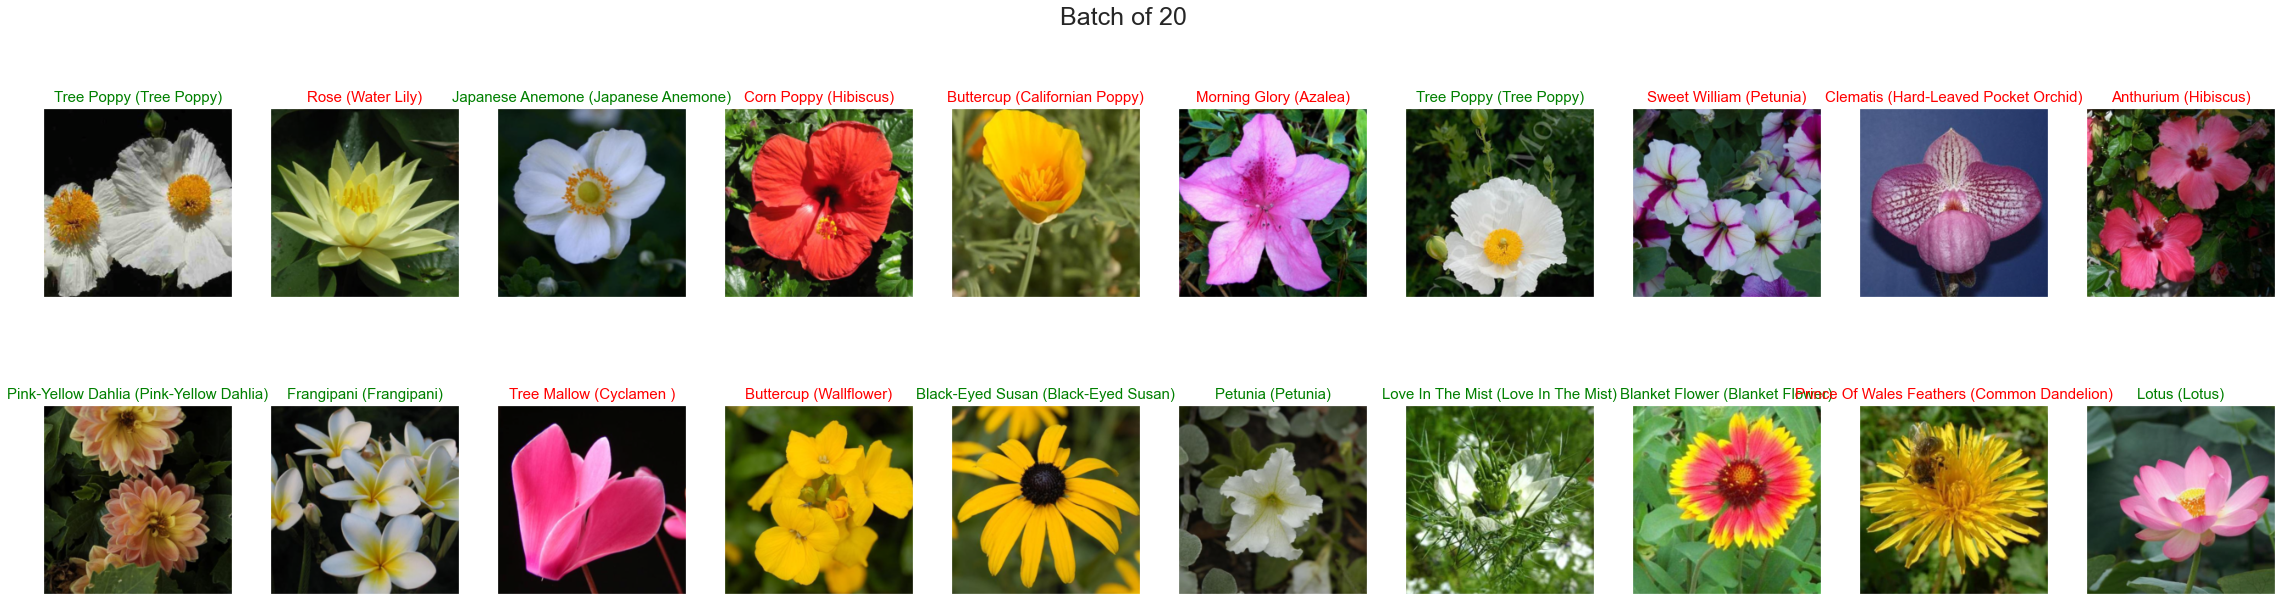

In [45]:
visualize.batch(test_iter, label_dict, n_batches, actual_order, use_cuda, model)

In [44]:
# def batch(iterable, dictionary, n_batch, actual_order, cuda=False, model=None):
#     invTrans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
#                                                         std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
#                                    transforms.Normalize(mean=[-0.485, -0.456, -0.406],
#                                                         std=[1., 1., 1.]), ])
#     images, targets = next(iterable)

#     if cuda:
#         images = images.cuda()
        
#     if model is not None:
#         output = model(images)
#         _, pred = torch.max(output, 1)
#         pred = np.squeeze(pred.numpy()) if not cuda else np.squeeze(pred.cpu().numpy())
    
#     images = invTrans(images)
#     images = images.numpy()
    
#     # plot the images in the batch, along with the corresponding labels
#     fig = plt.figure(figsize=(40, 10))
#     fig.suptitle(f'Batch of {n_batch}', fontsize=25)
#     for idx in np.arange(20):
#         ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
#         label = dictionary[int(actual_order[targets[idx]])]

#         if model is not None:
#             if cuda:
#                 images[idx] = images[idx].cpu()
#             img = np.transpose(np.clip(images[idx], 0, 1), (1, 2, 0))
#             plt.imshow(img)
#             pred_label = dictionary[int(actual_order[pred[idx]])]

#             ax.set_title('{} ({})'.format(pred_label, label),
#                          color=('green' if pred_label == label else 'red'),
#                          fontsize=15)
#         else:
#             img = np.transpose(np.clip(images[idx], 0, 1), (1, 2, 0))
#             plt.imshow(img)
#             ax.set_title(label, fontsize=15)

In [77]:
# def get_confusions(confused):
#     corrected = {}
#     for k, v in confused.items():
#         for val in v:
#             if val == k: continue
#             l1 = get_item(k)
#             l2 = get_item(val)
            
#             if l1 in corrected:
#                 if l2 in corrected[l1]:
#                     corrected[l1][l2] += 1
#                 else:
#                     corrected[l1][l2] = 0
#             else:
#                 corrected[l1] = {}
#     return corrected
            
            
# def get_item(idx):
#     return label_dict[int(actual_order[idx])]


# confused = get_confusions(confused_with)

In [110]:
def visualize_most_confused(target, confused_dict=None, top_k=3):
    paths = lambda x: get_image(label_inverse[x])
    
    temp = pd.DataFrame({'name': confused_dict[target].keys(), 'confused': confused_dict[target].values()})
    temp['paths'] = temp.name.apply(paths)

    temp.sort_values(by='confused', ascending=False, inplace=True)
    
    fig = px.histogram(temp, x='name', y='confused', title=f'Confused {target} with')
    fig.show()
    
    target_path = paths(target)
    top_paths = temp.iloc[:top_k, :]
    
    plt.title(f'Showing {target} with TOP {top_k} confusions')
    plt.imshow(Image.open(target_path))
    plt.show()
    
    fig = plt.figure(figsize=(10, 10))
    for idx in range(top_k):
        ax = fig.add_subplot(1, top_k + 1, idx + 1, xticks=[], yticks=[])
        plt.imshow(Image.open(top_paths.iloc[idx, 2]))
        ax.set_title(top_paths.iloc[idx, 0])
    plt.show()    


def get_image(idx):
    return random.choice([f'data/train/{idx}/{x}' for x in os.listdir(f'data/train/{idx}')])

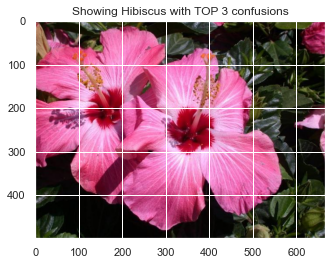

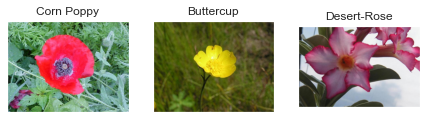

In [112]:
visualize_most_confused('Hibiscus', confused_dict=confused)

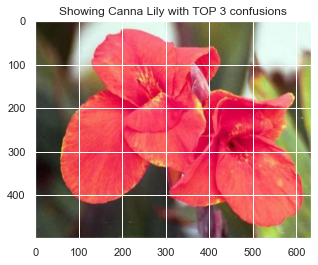

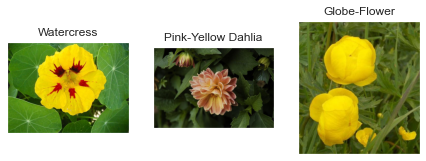

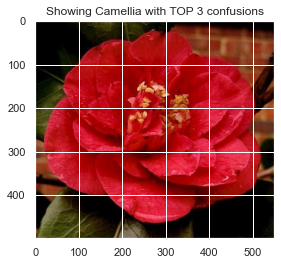

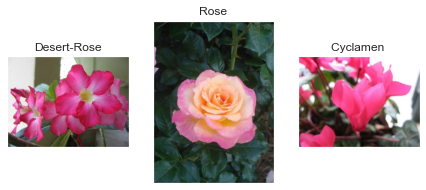

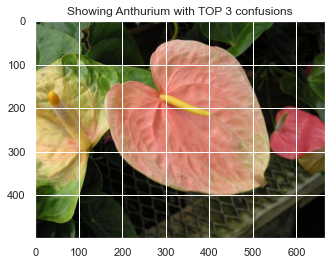

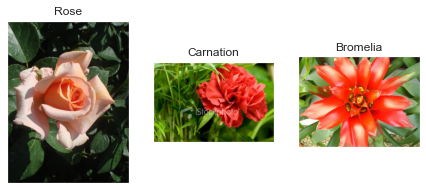

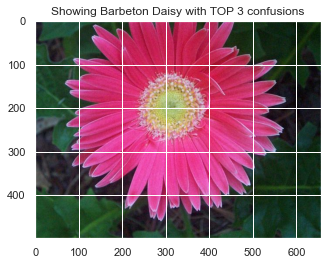

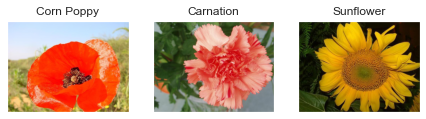

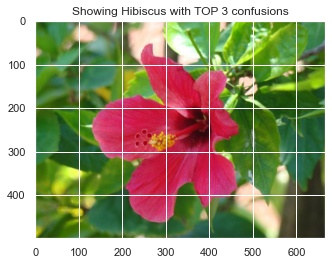

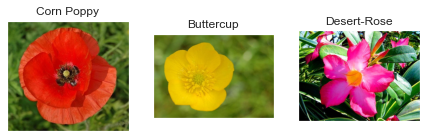

In [119]:
last_five = second_half.iloc[-5:, 0].to_list()

for last in last_five:
    visualize_most_confused(last, confused)

### Reference

